In [ ]:
# Install dependencies (run once)
# If running on Kaggle, these may already be present.

# Reproducibility & device
import random, os, torch, numpy as np
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device:', device)

# Project : Dental X-Ray Images Classification

This notebook aims to detect and classify dental diseases from panoramic X-ray images using a Swin Transformer model with self-supervised learning (Swin-SSL).  

**Key steps in this notebook:**
- **Exploratory Data Analysis (EDA):** Inspect dataset distribution, visualize samples, and analyze grayscale intensity patterns.
- **Data Preprocessing:** Apply image transformations suitable for model training.
- **Model Implementation:** Integrate and fine-tune the Swin-SSL architecture for dental X-ray classification.
- **Training & Validation:** Train the model, monitor performance, and adjust hyperparameters.
- **Evaluation:** Assess the trained model’s accuracy, loss curves, and classification performance metrics.


First we'll install the required libraries first

In [5]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from torchvision.transforms import RandAugment


from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import cv2
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report
from sklearn.metrics import confusion_matrix
from timm import create_model
from torchvision.datasets import ImageFolder
from torch.cuda.amp import GradScaler, autocast
from torch.utils.data import random_split
from collections import Counter
from timm.data import Mixup
from torchvision import datasets, transforms
import pandas as pd


from timm.loss import SoftTargetCrossEntropy  
from torch.cuda.amp import autocast

import os
import shutil
import random
import cv2
from tqdm import tqdm
from collections import defaultdict
from albumentations import (
    HorizontalFlip, RandomBrightnessContrast, Rotate, GaussianBlur, Compose
)


In [ ]:
# Verify dataset path and print class counts
import os
# Edit dataset_path variable below if required. If dataset_path exists in prior cells it will be used.
try:
    dataset_path
except NameError:
    # common default used in this project
    dataset_path = "/kaggle/working/augmented_dataset"

print("Checking dataset:", dataset_path)
if not os.path.exists(dataset_path):
    print("WARNING: dataset_path does not exist:", dataset_path)
else:
    classes = [d for d in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, d))]
    for c in sorted(classes):
        p = os.path.join(dataset_path, c)
        n = len([f for f in os.listdir(p) if f.lower().endswith(('.png','.jpg','.jpeg'))])
        print(f"  {c}: {n} images")


In [ ]:
# Local FocalLoss implementation (replaces dependency on torchtoolbox)
import torch.nn as nn
import torch.nn.functional as F
import torch

class FocalLoss(nn.Module):
    def __init__(self, alpha=1.0, gamma=2.0, reduction='mean'):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        # inputs: logits, targets: class indices
        ce = F.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-ce)
        loss = self.alpha * (1 - pt) ** self.gamma * ce
        if self.reduction == 'mean':
            return loss.mean()
        elif self.reduction == 'sum':
            return loss.sum()
        return loss


In [6]:
#GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device {device}")

Using device cuda


#### Loading the dataset

In [7]:
data_dir = "/kaggle/input/dental-opg-xray-dataset/Dental OPG XRAY Dataset/Dental OPG (Classification)"

classes = os.listdir(data_dir)

print(f"Classes: {classes}")

Classes: ['BDC-BDR', 'Infection', 'Impacted teeth', 'Caries', 'Healthy Teeth', 'Fractured Teeth']


#### Displaying sample images

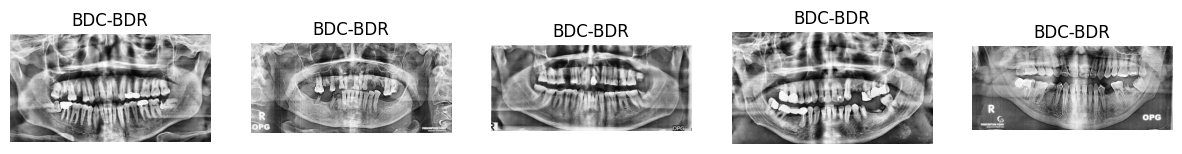

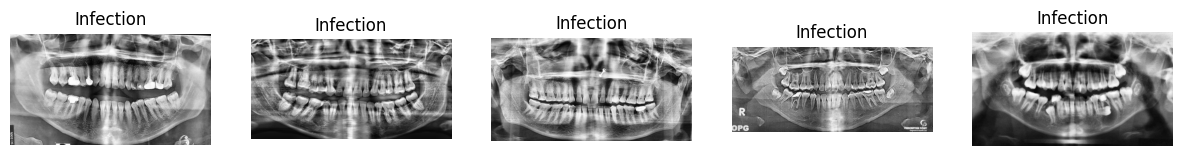

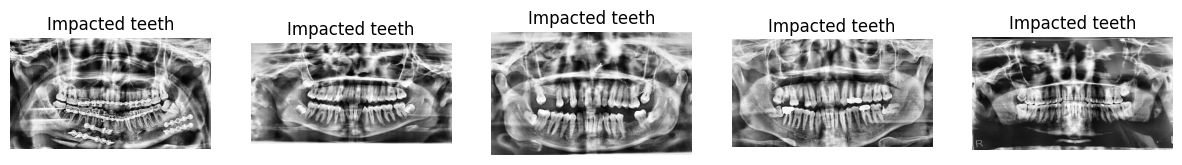

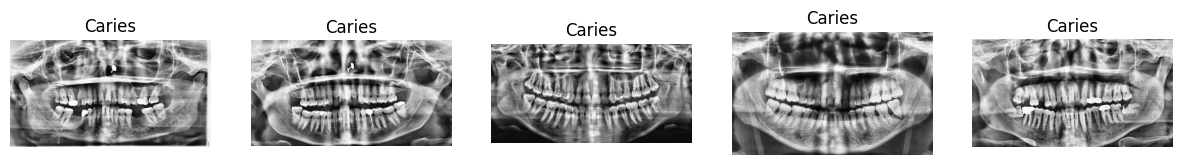

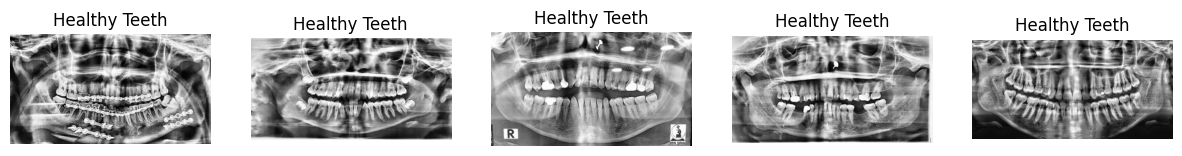

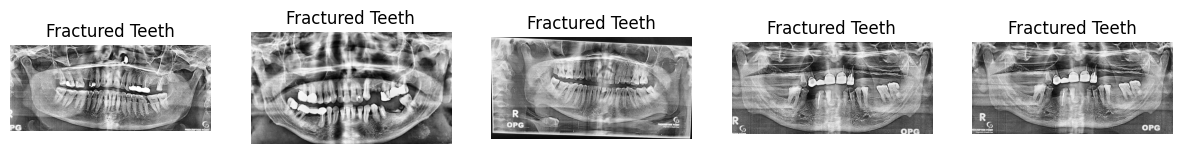

In [8]:
def plot_sample_images(class_name, n = 5):
    folder = os.path.join(data_dir, class_name)
    images = os.listdir(folder)[:n]
    plt.figure(figsize=(15, 5))
    for i, img_name in enumerate(images):
        img_path = os.path.join(folder, img_name)
        img = Image.open(img_path)
        plt.subplot(1, n, i + 1)
        plt.imshow(img.convert('L'), cmap='gray')
        plt.title(class_name)
        plt.axis('off')
    plt.show()

# Plot sample from each class
for cls in classes:
    plot_sample_images(cls)

We can observe that majority of the images are of Health Teeth, while the least are of Fractured Teeth. There is a huge imbalance of classes in the dataset. This might create bias predictions. We will handle this later using data augmentation or class sampling.

### Image Size Analysis

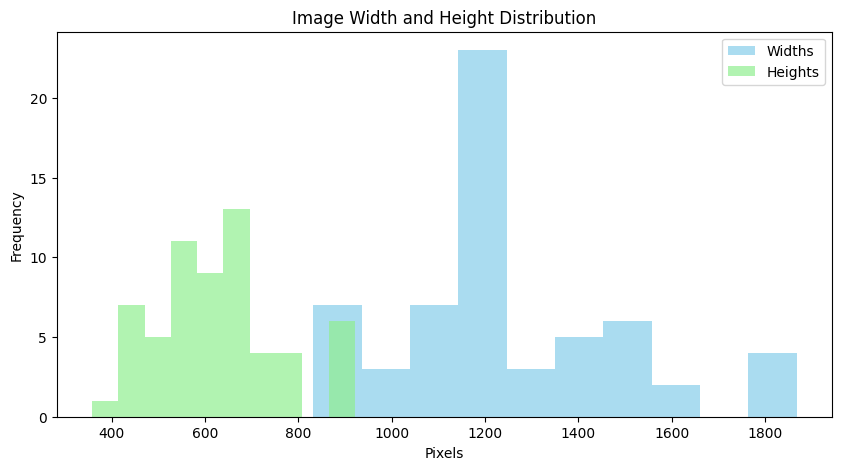

In [9]:
images_sizes = []
for class_name in os.listdir(data_dir):
    class_path = os.path.join(data_dir, class_name)
    images_files = os.listdir(class_path)[:10]
    for image_file in images_files:
        img_path = os.path.join(class_path, image_file)
        try:
            with Image.open(img_path) as img:
                images_sizes.append(img.size)

        except:
            continue

# Split sizes
widths, heights = zip(*images_sizes)

# Plot distributions
plt.figure(figsize=(10, 5))
plt.hist(widths, bins=10, alpha=0.7, label="Widths", color='skyblue')
plt.hist(heights, bins=10, alpha=0.7, label="Heights", color='lightgreen')
plt.title("Image Width and Height Distribution")
plt.xlabel("Pixels")
plt.ylabel("Frequency")
plt.legend()
plt.show()

### Image Size Analysis

The X-ray images show notable variation in dimensions, with widths ranging from 1000–1800 pixels and heights between 400–800 pixels. This confirms their panoramic nature.

To ensure consistent input shape for model training, all images will be resized to 224×224 pixels using standard transformations. Center cropping may also be applied to better preserve structure.

Standardizing image size is essential for reliable and efficient model training.


### Gray Scale Pixel Analysis

Min Pixel Value: 0
Max Pixel Value: 255
Mean Pixel Value: 138.11


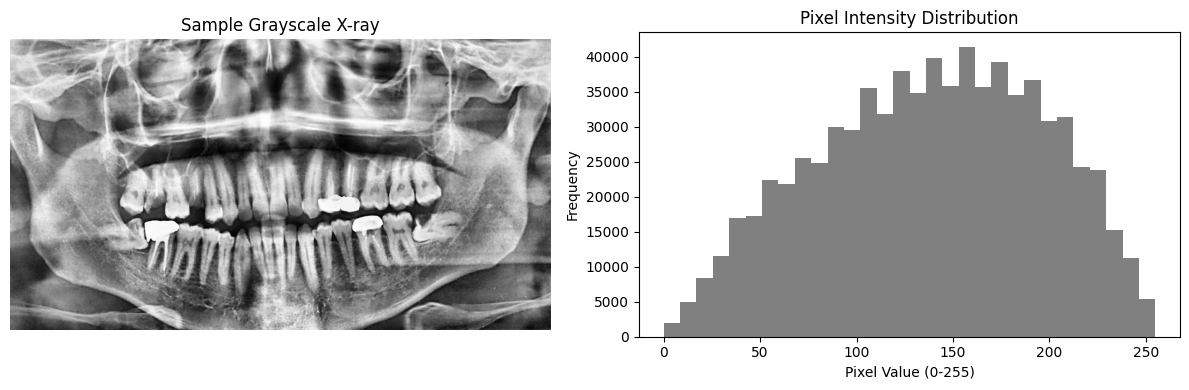

In [10]:
sample_class = os.listdir(data_dir)[0]
sample_img_path = os.path.join(data_dir, sample_class, os.listdir(os.path.join(data_dir, sample_class))[0])

image = Image.open(sample_img_path).convert('L')
image_np = np.array(image)

# Show stats
print(f"Min Pixel Value: {image_np.min()}")
print(f"Max Pixel Value: {image_np.max()}")
print(f"Mean Pixel Value: {image_np.mean():.2f}")

# Plot image and histogram
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.imshow(image_np, cmap='gray')
plt.title("Sample Grayscale X-ray")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.hist(image_np.flatten(), bins=30, color='gray')
plt.title("Pixel Intensity Distribution")
plt.xlabel("Pixel Value (0-255)")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()


The X-ray images are confirmed to be grayscale with pixel values ranging from **0 to 255**, and a mean intensity around **138**.

The distribution is fairly balanced, indicating good contrast across the dataset.

These insights support using standard grayscale normalization (`[0.5], [0.5]`) during preprocessing to stabilize training.

#### Dataset

In [13]:
dataset_path = "/kaggle/input/dental-opg-xray-dataset/Dental OPG XRAY Dataset/Dental OPG (Classification)"
print(os.listdir(dataset_path))

['BDC-BDR', 'Infection', 'Impacted teeth', 'Caries', 'Healthy Teeth', 'Fractured Teeth']


In [14]:
from collections import defaultdict

class_counts = defaultdict(int)

# Loop through class folders
for class_name in os.listdir(dataset_path):
    class_dir = os.path.join(dataset_path, class_name)
    if os.path.isdir(class_dir):
        num_images = len([f for f in os.listdir(class_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
        class_counts[class_name] = num_images

# Print the results
print(f"Total classes: {len(class_counts)}\n")
for cls, count in class_counts.items():
    print(f"{cls}: {count} images")

Total classes: 6

BDC-BDR: 52 images
Infection: 23 images
Impacted teeth: 87 images
Caries: 119 images
Healthy Teeth: 223 images
Fractured Teeth: 13 images


### Import all Library

In [15]:
target_path = "/kaggle/working/augmented_dataset"
target_per_class = 200
split_ratio = 0.8  # 80% train, 20% val
random.seed(42)

# ========== AUGMENTATION TRANSFORMS ==========
transform = Compose([
    HorizontalFlip(p=0.5),
    Rotate(limit=15, p=0.7),
    RandomBrightnessContrast(p=0.5),
    GaussianBlur(blur_limit=3, p=0.3),
])

def augment_image(img):
    augmented = transform(image=img)
    return augmented['image']


# ========== CREATE AUGMENTED DATA ==========
os.makedirs(target_path, exist_ok=True)

for class_name in os.listdir(dataset_path):
    src_dir = os.path.join(dataset_path, class_name)
    tgt_dir = os.path.join(target_path, class_name)
    os.makedirs(tgt_dir, exist_ok=True)

    images = [f for f in os.listdir(src_dir) if f.lower().endswith(('.jpg', '.png', '.jpeg'))]
    image_paths = [os.path.join(src_dir, f) for f in images]

    # Step 1: Copy originals
    for img_file in images:
        shutil.copy(os.path.join(src_dir, img_file), os.path.join(tgt_dir, img_file))

    # Step 2: Generate more if needed
    needed = target_per_class - len(images)
    if needed <= 0:
        continue

    print(f"[{class_name}] Augmenting {needed} images...")

    for i in tqdm(range(needed)):
        rand_img_path = random.choice(image_paths)
        img = cv2.imread(rand_img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        aug_img = augment_image(img)
        aug_img = cv2.cvtColor(aug_img, cv2.COLOR_RGB2BGR)

        out_path = os.path.join(tgt_dir, f"aug_{i}_{os.path.basename(rand_img_path)}")
        cv2.imwrite(out_path, aug_img)

print("All classes now have 200 images each.")

[BDC-BDR] Augmenting 148 images...


100%|██████████| 148/148 [00:02<00:00, 61.84it/s]


[Infection] Augmenting 177 images...


100%|██████████| 177/177 [00:03<00:00, 56.28it/s]


[Impacted teeth] Augmenting 113 images...


100%|██████████| 113/113 [00:01<00:00, 58.95it/s]


[Caries] Augmenting 81 images...


100%|██████████| 81/81 [00:01<00:00, 59.26it/s]


[Fractured Teeth] Augmenting 187 images...


100%|██████████| 187/187 [00:03<00:00, 59.95it/s]

All classes now have 200 images each.


In [16]:
random.seed(42)

augmented_path = "/kaggle/working/augmented_dataset"
healthy_class = "Healthy Teeth"
target_healthy_count = 200

healthy_dir = os.path.join(augmented_path, healthy_class)
all_healthy_images = os.listdir(healthy_dir)

print(f"Original Healthy Teeth images: {len(all_healthy_images)}")

if len(all_healthy_images) > target_healthy_count:
    # Randomly select images to keep
    selected_images = random.sample(all_healthy_images, target_healthy_count)

    # Remove unselected images
    for img in all_healthy_images:
        if img not in selected_images:
            os.remove(os.path.join(healthy_dir, img))
    print(f"Downsampled Healthy Teeth images to: {target_healthy_count}")
else:
    print("No downsampling needed, already at or below target count.")

Original Healthy Teeth images: 223
Downsampled Healthy Teeth images to: 200


### Dataset Augmentation, Preprocessing

In [17]:
dataset_path = "/kaggle/working/augmented_dataset"  

dataset = ImageFolder(root=dataset_path)

print("Classes:", dataset.classes)
print("Class-to-Index Mapping:", dataset.class_to_idx)

# Count number of samples per class index
labels = [sample[1] for sample in dataset.samples]
class_counts = Counter(labels)

# Print class distribution nicely
print("Class Distribution:")
for class_idx, count in class_counts.items():
    print(f"  {dataset.classes[class_idx]}: {count} images")


Classes: ['BDC-BDR', 'Caries', 'Fractured Teeth', 'Healthy Teeth', 'Impacted teeth', 'Infection']
Class-to-Index Mapping: {'BDC-BDR': 0, 'Caries': 1, 'Fractured Teeth': 2, 'Healthy Teeth': 3, 'Impacted teeth': 4, 'Infection': 5}
Class Distribution:
  BDC-BDR: 200 images
  Caries: 200 images
  Fractured Teeth: 200 images
  Healthy Teeth: 200 images
  Impacted teeth: 200 images
  Infection: 200 images


### CLAHETransform using this dataset

In [18]:
class CLAHETransform:
    def __init__(self, clip_limit=2.0, tile_grid_size=(8, 8)):
        self.clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_grid_size)
    
    def __call__(self, img):
        img_np = np.array(img.convert("L"))
        img_clahe = self.clahe.apply(img_np)
        return Image.fromarray(img_clahe).convert("RGB")

In [19]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from torchvision import transforms

# Define transformations
transform_train = transforms.Compose([\n    transforms.Grayscale(num_output_channels=3), 
    CLAHETransform(),
    transforms.RandomResizedCrop((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.3, contrast=0.3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

])

transform_test = transforms.Compose([\n    transforms.Grayscale(num_output_channels=3), 
    CLAHETransform(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

])

# Load entire balanced dataset (200x6 = 1200 images)
dataset = datasets.ImageFolder(root="/kaggle/working/augmented_dataset", transform=transform_train)


### Load the dataset

In [20]:
# Split sizes (70% train, 20% val, 10% test)
total_size = len(dataset)
train_size = int(0.7 * total_size)
val_size = int(0.2 * total_size)
test_size = total_size - train_size - val_size

# Perform the split
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Apply transform_test to val and test sets
val_dataset.dataset.transform = transform_test
test_dataset.dataset.transform = transform_test

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Confirm dataset sizes
print("Train Dataset Size:", len(train_dataset))
print("Validation Dataset Size:", len(val_dataset))
print("Test Dataset Size:", len(test_dataset))

Train Dataset Size: 840
Validation Dataset Size: 240
Test Dataset Size: 120


## Model: Swin Transformer (swin_tiny_patch4_window7_224)

This model is based on the **Swin Transformer** architecture with the following configuration:
- **Patch Size:** 4 × 4  
- **Window Size:** 7  
- **Input Resolution:** 224 × 224 pixels  

The Swin Transformer is a hierarchical Vision Transformer that computes self-attention within shifted windows, enabling:
- Efficient computation for high-resolution images
- Strong performance across various vision tasks
- Better locality and inductive bias compared to vanilla Vision Transformers

In this notebook, the `swin_tiny_patch4_window7_224` variant is used due to its lightweight design, making it suitable for medical imaging tasks while maintaining strong accuracy.


In [21]:
# Define model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = create_model('swin_tiny_patch4_window7_224', pretrained=True, num_classes=6,drop_path_rate=0.3)
model.to(device)

SwinTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
    (norm): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
  )
  (layers): Sequential(
    (0): SwinTransformerStage(
      (downsample): Identity()
      (blocks): Sequential(
        (0): SwinTransformerBlock(
          (norm1): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
          (attn): WindowAttention(
            (qkv): Linear(in_features=96, out_features=288, bias=True)
            (attn_drop): Dropout(p=0.0, inplace=False)
            (proj): Linear(in_features=96, out_features=96, bias=True)
            (proj_drop): Dropout(p=0.0, inplace=False)
            (softmax): Softmax(dim=-1)
          )
          (drop_path1): Identity()
          (norm2): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
          (mlp): Mlp(
            (fc1): Linear(in_features=96, out_features=384, bias=True)
            (act): GELU(approximate='none')
            (drop1): 

In [22]:
from timm.data import Mixup
from timm.loss import SoftTargetCrossEntropy  # Required for mixup
from torch.cuda.amp import autocast
# Define optimizer, criterion, scaler

mixup_fn = Mixup(
    mixup_alpha=0.4,
    cutmix_alpha=1.0,
    cutmix_minmax=None,
    prob=1.0,
    switch_prob=0.5,
    mode='batch',
    label_smoothing=0.1,
    num_classes=6
)

from sklearn.utils.class_weight import compute_class_weight

# class_weights = compute_class_weight(class_weight='balanced', classes=np.arange(6), y=val_labels)
# class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)
# Get integer labels from the validation subset
val_indices = val_dataset.indices if hasattr(val_dataset, 'indices') else range(len(val_dataset))
val_labels_full = [dataset.samples[i][1] for i in val_indices]

# Compute class weights from val label distribution
class_weights = compute_class_weight(class_weight='balanced', classes=np.arange(6), y=val_labels_full)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

#criterion = nn.CrossEntropyLoss()
#criterion = FocalLoss(gamma=2.0,classes=6)
#criterion = SoftTargetCrossEntropy()
#train_criterion = FocalLoss(gamma=2.0,classes=6)
train_criterion = SoftTargetCrossEntropy()  # for mixup
val_criterion = nn.CrossEntropyLoss(weight=class_weights)       # for integer labels

optimizer = optim.Adam(model.parameters(), lr=1e-4,weight_decay=1e-5)

from timm.scheduler import CosineLRScheduler

scheduler = CosineLRScheduler(
    optimizer,
    t_initial=25,         # Set this to total number of epochs
    lr_min=1e-6,          # Final learning rate
    warmup_lr_init=1e-6,  # Starting LR for warmup
    warmup_t=3,           # Number of warmup epochs
    cycle_limit=1
)

scaler = torch.cuda.amp.GradScaler()



# Training and validation functions
def train_one_epoch(model, loader, optimizer, criterion, scaler):
    model.train()
    total_loss, preds, labels = 0, [], []
    for images, targets in loader:
        images, targets = images.to(device), targets.to(device)
        images, targets = mixup_fn(images, targets)
        optimizer.zero_grad()
        with autocast():
            outputs = model(images)
            loss = criterion(outputs, targets)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        total_loss += loss.item() * images.size(0)
        preds += torch.argmax(outputs, dim=1).cpu().tolist()
        #labels += targets.cpu().tolist()
        labels += torch.argmax(targets, dim=1).cpu().tolist()
    avg_loss = total_loss / len(loader.dataset)
    return avg_loss, preds, labels

def validate(model, loader, criterion):
    model.eval()
    total_loss, preds, labels = 0, [], []
    with torch.no_grad():
        for images, targets in loader:
            images, targets = images.to(device), targets.to(device)
            outputs = model(images)
            loss = criterion(outputs, targets)

            total_loss += loss.item() * images.size(0)
            preds += torch.argmax(outputs, dim=1).cpu().tolist()
            labels += targets.cpu().tolist()
    avg_loss = total_loss / len(loader.dataset)
    return avg_loss, preds, labels

/tmp/ipykernel_144/2354025390.py:49: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


In [23]:
# Training loop
num_epochs = 25
train_log = []
val_log = []

for epoch in range(1, num_epochs + 1):
    train_loss, train_preds, train_labels = train_one_epoch(model, train_loader, optimizer, train_criterion, scaler)
    val_loss, val_preds, val_labels = validate(model, val_loader, val_criterion)

    scheduler.step(epoch) 
    
    train_acc = (torch.tensor(train_preds) == torch.tensor(train_labels)).float().mean().item()
    val_acc = (torch.tensor(val_preds) == torch.tensor(val_labels)).float().mean().item()

    train_f1 = f1_score(train_labels, train_preds, average='macro')
    val_f1 = f1_score(val_labels, val_preds, average='macro')

    train_log.append({"epoch": epoch, "loss": train_loss, "acc": train_acc, "f1": train_f1})
    val_log.append({"epoch": epoch, "loss": val_loss, "acc": val_acc, "f1": val_f1})

    if epoch % 5 == 0 or epoch == 1:
        print(f"Epoch {epoch}")
        print(f"Train Loss: {train_loss:.4f}, Accuracy: {train_acc:.4f}, F1: {train_f1:.4f}")
        print(f"Val   Loss: {val_loss:.4f}, Accuracy: {val_acc:.4f}, F1: {val_f1:.4f}")
    else:
        print(f"Epoch {epoch}: Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")

# Classification report for validation
print("\nValidation Classification Report:")
print(classification_report(val_labels, val_preds, target_names=dataset.classes))

/tmp/ipykernel_144/2354025390.py:61: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 1
Train Loss: 1.8069, Accuracy: 0.1857, F1: 0.1667
Val   Loss: 1.7762, Accuracy: 0.2125, F1: 0.1884


/tmp/ipykernel_144/2354025390.py:61: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 2: Train Acc: 0.1952, Val Acc: 0.3292


/tmp/ipykernel_144/2354025390.py:61: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 3: Train Acc: 0.2738, Val Acc: 0.3500


/tmp/ipykernel_144/2354025390.py:61: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 4: Train Acc: 0.3071, Val Acc: 0.2667


/tmp/ipykernel_144/2354025390.py:61: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 5
Train Loss: 1.6466, Accuracy: 0.3476, F1: 0.3242
Val   Loss: 1.4324, Accuracy: 0.3917, F1: 0.3524


/tmp/ipykernel_144/2354025390.py:61: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 6: Train Acc: 0.4107, Val Acc: 0.4542


/tmp/ipykernel_144/2354025390.py:61: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 7: Train Acc: 0.4488, Val Acc: 0.4417


/tmp/ipykernel_144/2354025390.py:61: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 8: Train Acc: 0.4881, Val Acc: 0.4583


/tmp/ipykernel_144/2354025390.py:61: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 9: Train Acc: 0.5083, Val Acc: 0.4417


/tmp/ipykernel_144/2354025390.py:61: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 10
Train Loss: 1.4960, Accuracy: 0.5226, F1: 0.5125
Val   Loss: 1.3439, Accuracy: 0.4333, F1: 0.4242


/tmp/ipykernel_144/2354025390.py:61: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 11: Train Acc: 0.5262, Val Acc: 0.4708


/tmp/ipykernel_144/2354025390.py:61: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 12: Train Acc: 0.5488, Val Acc: 0.3833


/tmp/ipykernel_144/2354025390.py:61: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 13: Train Acc: 0.5655, Val Acc: 0.4500


/tmp/ipykernel_144/2354025390.py:61: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 14: Train Acc: 0.6298, Val Acc: 0.4667


/tmp/ipykernel_144/2354025390.py:61: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 15
Train Loss: 1.2938, Accuracy: 0.5964, F1: 0.5915
Val   Loss: 1.3484, Accuracy: 0.4708, F1: 0.4565


/tmp/ipykernel_144/2354025390.py:61: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 16: Train Acc: 0.6750, Val Acc: 0.4417


/tmp/ipykernel_144/2354025390.py:61: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 17: Train Acc: 0.6143, Val Acc: 0.4500


/tmp/ipykernel_144/2354025390.py:61: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 18: Train Acc: 0.6452, Val Acc: 0.4292


/tmp/ipykernel_144/2354025390.py:61: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 19: Train Acc: 0.6369, Val Acc: 0.4333


/tmp/ipykernel_144/2354025390.py:61: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 20
Train Loss: 1.2546, Accuracy: 0.6536, F1: 0.6469
Val   Loss: 1.4690, Accuracy: 0.4625, F1: 0.4557


/tmp/ipykernel_144/2354025390.py:61: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 21: Train Acc: 0.6762, Val Acc: 0.4500


/tmp/ipykernel_144/2354025390.py:61: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 22: Train Acc: 0.6643, Val Acc: 0.4625


/tmp/ipykernel_144/2354025390.py:61: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 23: Train Acc: 0.7012, Val Acc: 0.4583


/tmp/ipykernel_144/2354025390.py:61: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 24: Train Acc: 0.6798, Val Acc: 0.4625


/tmp/ipykernel_144/2354025390.py:61: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 25
Train Loss: 1.1857, Accuracy: 0.7083, F1: 0.7017
Val   Loss: 1.4633, Accuracy: 0.4542, F1: 0.4454

Validation Classification Report:
                 precision    recall  f1-score   support

        BDC-BDR       0.40      0.53      0.46        36
         Caries       0.16      0.18      0.17        33
Fractured Teeth       0.70      0.72      0.71        32
  Healthy Teeth       0.22      0.13      0.17        45
 Impacted teeth       0.53      0.44      0.48        55
      Infection       0.61      0.79      0.69        39

       accuracy                           0.45       240
      macro avg       0.44      0.47      0.45       240
   weighted avg       0.44      0.45      0.44       240



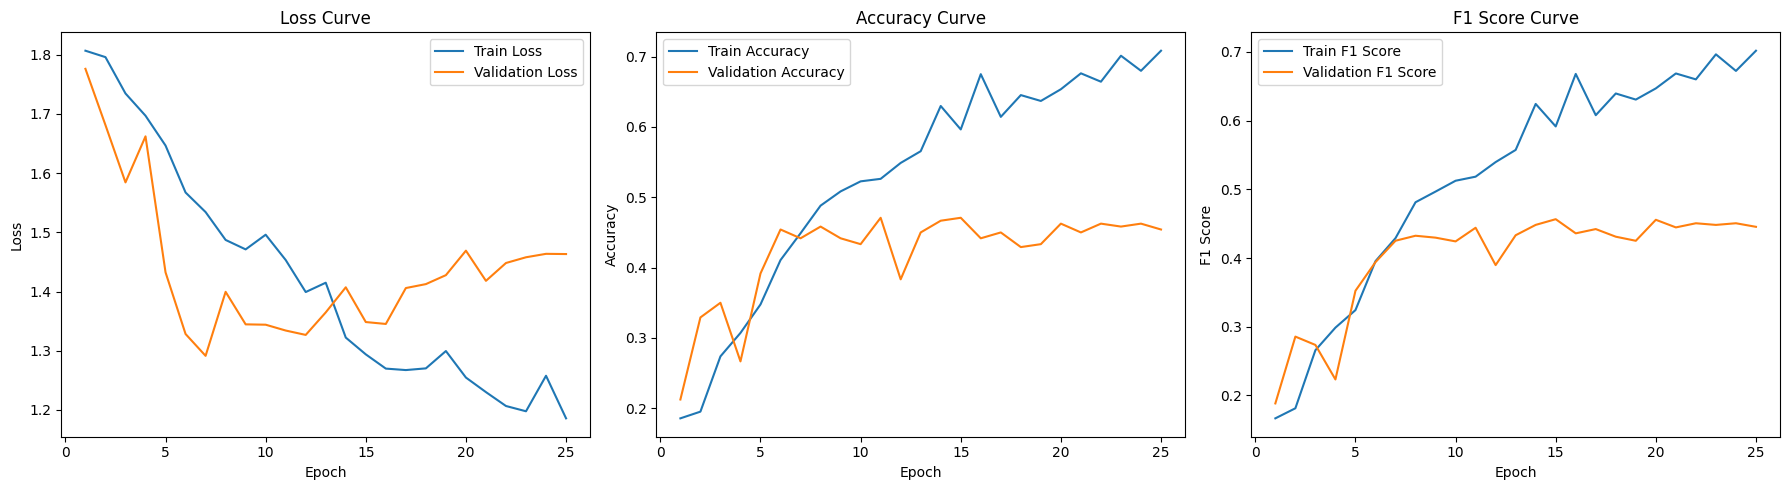

In [24]:
import matplotlib.pyplot as plt

# Extract metrics from logs
epochs = [log['epoch'] for log in train_log]

train_losses = [log['loss'] for log in train_log]
val_losses = [log['loss'] for log in val_log]

train_accs = [log['acc'] for log in train_log]
val_accs = [log['acc'] for log in val_log]

train_f1s = [log['f1'] for log in train_log]
val_f1s = [log['f1'] for log in val_log]

plt.figure(figsize=(18, 5))

# Loss curve
plt.subplot(1, 3, 1)
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()

# Accuracy curve
plt.subplot(1, 3, 2)
plt.plot(epochs, train_accs, label='Train Accuracy')
plt.plot(epochs, val_accs, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Curve')
plt.legend()

# F1 score curve
plt.subplot(1, 3, 3)
plt.plot(epochs, train_f1s, label='Train F1 Score')
plt.plot(epochs, val_f1s, label='Validation F1 Score')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.title('F1 Score Curve')
plt.legend()

plt.tight_layout()
plt.show()

In [25]:
test_criterion = nn.CrossEntropyLoss() 
test_loss, test_preds, test_labels = validate(model, test_loader, test_criterion)
print("\nTest Classification Report:")
print(classification_report(test_labels, test_preds, target_names=dataset.classes))


Test Classification Report:
                 precision    recall  f1-score   support

        BDC-BDR       0.50      0.39      0.44        23
         Caries       0.18      0.24      0.21        17
Fractured Teeth       0.65      0.72      0.68        18
  Healthy Teeth       0.25      0.31      0.28        16
 Impacted teeth       0.19      0.19      0.19        16
      Infection       0.83      0.67      0.74        30

       accuracy                           0.45       120
      macro avg       0.43      0.42      0.42       120
   weighted avg       0.49      0.45      0.46       120



# DINO

In [27]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import timm
import copy

class DINOLoss(nn.Module):
    def __init__(self, out_dim=65536, teacher_temp=0.07, student_temp=0.1, center_momentum=0.9):
        super().__init__()
        self.student_temp = student_temp
        self.teacher_temp = teacher_temp
        self.center_momentum = center_momentum
        self.register_buffer('center', torch.zeros(1, out_dim))

    def forward(self, student_output, teacher_output):
        student_out = student_output / self.student_temp
        student_out = F.log_softmax(student_out, dim=-1)

        teacher_out = F.softmax((teacher_output - self.center) / self.teacher_temp, dim=-1)
        teacher_out = teacher_out.detach()

        loss = -torch.sum(teacher_out * student_out, dim=-1).mean()
        self.update_center(teacher_output)
        return loss

    @torch.no_grad()
    def update_center(self, teacher_output):
        batch_center = torch.mean(teacher_output, dim=0, keepdim=True)
        self.center = self.center * self.center_momentum + batch_center * (1 - self.center_momentum)

In [28]:
# Swin Transformer for DINO (output 65536 dim)
student = timm.create_model('swin_tiny_patch4_window7_224', pretrained=False, num_classes=65536)
teacher = copy.deepcopy(student)
for p in teacher.parameters():
    p.requires_grad = False

In [29]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
student = student.to(device)
teacher = teacher.to(device)
dino_loss = DINOLoss().to(device)


# if torch.cuda.device_count() > 1:
#     print(f"Using {torch.cuda.device_count()} GPUs")
#     student = nn.DataParallel(student)
#     teacher = nn.DataParallel(teacher)
#     dino_loss = nn.DataParallel(dino_loss)

optimizer = torch.optim.AdamW(student.parameters(), lr=1e-4, weight_decay=1e-4)

# Use your real DataLoader with images only (no labels needed)
from timm.scheduler import CosineLRScheduler

# After defining your optimizer
scheduler = CosineLRScheduler(
    optimizer,
    t_initial=100,  # Total DINO epochs
    lr_min=1e-6,    # Final learning rate
    warmup_lr_init=1e-6,
    warmup_t=10,    # Warmup for first 10 epochs
    cycle_limit=1,
)
for epoch in range(100):
    student.train()
    running_loss = 0.0
    num_batches = 0

    for images, _ in train_loader:  # Use labels only as placeholders
        images = images.to(device)

        student_out = student(images)
        with torch.no_grad():
            teacher_out = teacher(images)

        loss = dino_loss(student_out, teacher_out)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        num_batches += 1

    scheduler.step(epoch)
    # EMA update
    
    with torch.no_grad():
        for ps, pt in zip(student.parameters(), teacher.parameters()):
            pt.data = 0.996 * pt.data + (1 - 0.996) * ps.data

    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}/100, Avg DINO Loss: {running_loss / num_batches:.4f}")

# Save pretrained backbone
torch.save(student.state_dict(), "dino_pretrained_swin.pth")

Epoch 10/100, Avg DINO Loss: 9.5856
Epoch 20/100, Avg DINO Loss: 9.3458
Epoch 30/100, Avg DINO Loss: 9.2934
Epoch 40/100, Avg DINO Loss: 9.1361
Epoch 50/100, Avg DINO Loss: 9.0046
Epoch 60/100, Avg DINO Loss: 8.9006
Epoch 70/100, Avg DINO Loss: 8.7991
Epoch 80/100, Avg DINO Loss: 8.6626
Epoch 90/100, Avg DINO Loss: 8.6184
Epoch 100/100, Avg DINO Loss: 8.5331


In [30]:
import torch
import torch.nn as nn
import timm
from sklearn.metrics import precision_score, recall_score, f1_score

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load DINO-pretrained model with classifier removed
backbone = timm.create_model('swin_tiny_patch4_window7_224', pretrained=False, num_classes=0)
backbone.load_state_dict(torch.load("dino_pretrained_swin.pth"), strict=False)

# DINOClassifier assumes Swin-Tiny outputs 768-dim features
class DINOClassifier(nn.Module):
    def __init__(self, backbone, feature_dim=768, num_classes=6):
        super().__init__()
        self.backbone = backbone
        self.classifier = nn.Linear(feature_dim, num_classes)

    def forward(self, x):
        features = self.backbone(x)  # shape: [B, 768]
        return self.classifier(features)

model = DINOClassifier(backbone, feature_dim=768, num_classes=6).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)

# Training Loop
for epoch in range(20):
    model.train()
    train_loss = 0.0
    all_preds, all_labels = [], []

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        all_preds.extend(outputs.argmax(dim=1).cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    # Safe metric calculations
    train_precision = precision_score(all_labels, all_preds, average='macro', zero_division=0)
    train_recall = recall_score(all_labels, all_preds, average='macro', zero_division=0)
    train_f1 = f1_score(all_labels, all_preds, average='macro', zero_division=0)

    print(f"[Epoch {epoch+1}] Train Loss: {train_loss:.4f}, Precision: {train_precision:.4f}, Recall: {train_recall:.4f}, F1: {train_f1:.4f}")


[Epoch 1] Train Loss: 49.0055, Precision: 0.2044, Recall: 0.2032, F1: 0.1985
[Epoch 2] Train Loss: 45.8732, Precision: 0.2854, Recall: 0.2824, F1: 0.2731
[Epoch 3] Train Loss: 44.1775, Precision: 0.3162, Recall: 0.3176, F1: 0.3079
[Epoch 4] Train Loss: 41.6164, Precision: 0.3563, Recall: 0.3666, F1: 0.3542
[Epoch 5] Train Loss: 38.4803, Precision: 0.4063, Recall: 0.4110, F1: 0.4012
[Epoch 6] Train Loss: 35.7439, Precision: 0.4568, Recall: 0.4595, F1: 0.4521
[Epoch 7] Train Loss: 30.8317, Precision: 0.5544, Recall: 0.5636, F1: 0.5573
[Epoch 8] Train Loss: 28.7422, Precision: 0.5947, Recall: 0.5992, F1: 0.5959
[Epoch 9] Train Loss: 25.0401, Precision: 0.6637, Recall: 0.6701, F1: 0.6656
[Epoch 10] Train Loss: 22.7730, Precision: 0.6608, Recall: 0.6687, F1: 0.6638
[Epoch 11] Train Loss: 22.6821, Precision: 0.6773, Recall: 0.6807, F1: 0.6774
[Epoch 12] Train Loss: 22.1984, Precision: 0.6937, Recall: 0.6924, F1: 0.6925
[Epoch 13] Train Loss: 20.9958, Precision: 0.7138, Recall: 0.7183, F1: 0.

In [31]:
for images, labels in train_loader:
    student_out = student(images.to(device))
    print("Output shape:", student_out.shape)  
    preds = student_out.argmax(dim=1)
    print("Sample preds:", preds[:5].cpu().numpy())
    print("Sample labels:", labels[:5].numpy())
    break

Output shape: torch.Size([32, 65536])
Sample preds: [31578 15538 41075 12244 19097]
Sample labels: [5 3 5 4 1]


In [35]:
target_names = dataset.classes
report = classification_report(all_labels, all_preds, target_names=target_names, digits=4)
print(f"\n[Epoch {epoch+1}] Classification Report:\n{report}")


[Epoch 20] Classification Report:
                 precision    recall  f1-score   support

        BDC-BDR     0.7554    0.7447    0.7500       141
         Caries     0.6429    0.6600    0.6513       150
Fractured Teeth     0.8987    0.9467    0.9221       150
  Healthy Teeth     0.5620    0.5540    0.5580       139
 Impacted teeth     0.7398    0.7054    0.7222       129
      Infection     0.8837    0.8702    0.8769       131

       accuracy                         0.7476       840
      macro avg     0.7471    0.7468    0.7468       840
   weighted avg     0.7465    0.7476    0.7469       840



# Attention Rollout

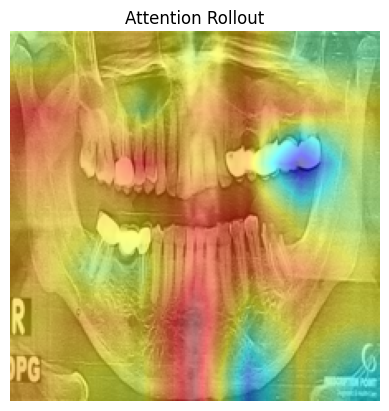

In [36]:
# --- Load image and preprocess ---
img_path = "/kaggle/working/augmented_dataset/BDC-BDR/101.jpg"
original_image = Image.open(img_path).convert("RGB")
transform = transforms.Compose([\n    transforms.Grayscale(num_output_channels=3), 
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])
input_tensor = transform(original_image).unsqueeze(0).to(device)  # shape: (1, 3, 224, 224)

# --- Hook to extract attention weights ---
attention_maps = []

def get_attention_hook(module, input, output):
    # Output shape: (B, Heads, Tokens, Tokens)
    attention_maps.append(output)

# --- Register hooks on all attention layers ---
hooks = []
for name, module in model.named_modules():
    if 'attn.attn_drop' in name:  # Works well for Swin
        hooks.append(module.register_forward_hook(get_attention_hook))

# --- Forward pass ---
with torch.no_grad():
    _ = model(input_tensor)

# --- Clean up hooks ---
for hook in hooks:
    hook.remove()

# --- Compute Attention Rollout ---
# Sum all heads and average across layers
def compute_rollout(attn_list):
    result = torch.eye(attn_list[0].size(-1)).to(device)
    for attn in attn_list:
        attn_heads_fused = attn.mean(dim=1)  # Average over heads: (B, Tokens, Tokens)
        attn_heads_fused = attn_heads_fused[0]  # Remove batch dim
        attn_heads_fused += torch.eye(attn_heads_fused.size(0)).to(device)  # add residual
        attn_heads_fused /= attn_heads_fused.sum(dim=-1, keepdim=True)
        result = torch.matmul(attn_heads_fused, result)
    return result

rollout = compute_rollout(attention_maps)  # Shape: (tokens, tokens)

# --- Convert rollout to spatial map ---
# For Swin Transformer, patch count varies — 
# Get attention to image patches 
num_patches = int(np.sqrt(rollout.shape[0]))  
attn_map = rollout[0].reshape(num_patches, num_patches).cpu().numpy()


# Resize attention to match image size

attn_resized = cv2.resize(attn_map, (224, 224))

# --- Normalize and overlay ---
attn_normalized = (attn_resized - attn_resized.min()) / (attn_resized.max() - attn_resized.min())
heatmap = np.uint8(255 * attn_normalized)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
heatmap = np.float32(heatmap) / 255

rgb_image = np.array(original_image.resize((224, 224))).astype(np.float32) / 255.0
overlay = heatmap * 0.5 + rgb_image * 0.5

# --- Show Result ---
plt.imshow(overlay)
plt.title("Attention Rollout")
plt.axis('off')
plt.show()


## Confusion Matrix

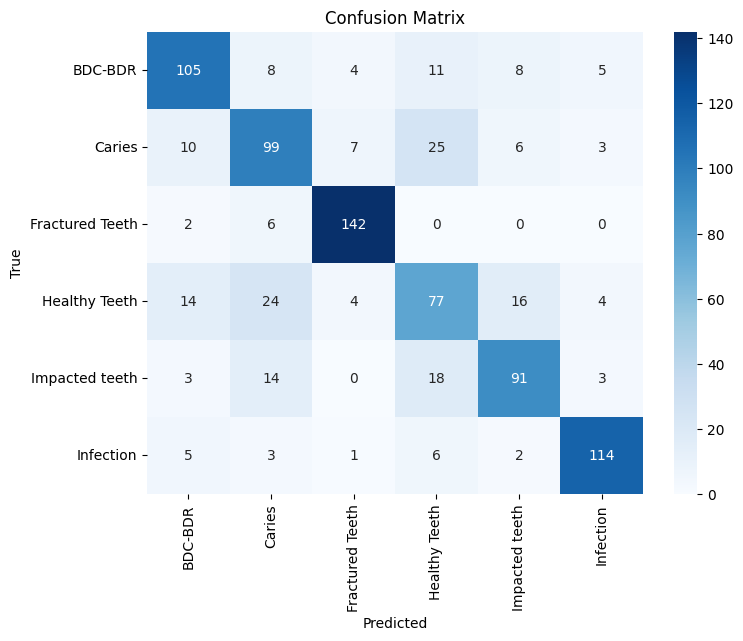

In [37]:
y_true = all_labels
y_pred = all_preds

# Now plot confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

## Conclusion

EDA (including grayscale analysis) was kept. The notebook fine-tunes a Swin-Tiny (`swin_tiny_patch4_window7_224`) model on the prepared dataset, converts grayscale images to 3-channel inputs, and saves the final checkpoint `swin_finetuned_dental.pth` for integration into your app.

**Next steps:** hyperparameter tuning, address class imbalance, and convert the model to ONNX/TorchScript for deployment.